<img src="../static/aeropython_name_mini.png" alt="AeroPython" style="width: 300px;"/>

# Clase 2d: Ecuaciones diferenciales ordinarias (EDOs)

_¿Te acuerdas de todos esos esquemas numéricos para integrar ecuaciones diferenciales ordinarias? Es bueno saber que existen y qué peculiaridades tiene cada uno, pero en este curso no queremos implementar esos esquemas: queremos resolver las ecuaciones. Los problemas de evolución están por todas partes en ingeniería y son de los más divertidos de programar._

Nos basaremos en algunos de los ejemplos de https://mat.caminos.upm.es/wiki/Categor%C3%ADa:Ecuaciones_Diferenciales

In [1]:
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## Decaimiento exponencial y oscilador armónico

### Fundamentos

Para integrar EDOs vamos a usar la función `odeint` del paquete `integrate`, que permite integrar sistemas del tipo:

$$ \frac{d\mathbf{y}}{dt}=\mathbf{f}\left(\mathbf{y},t\right)$$

con condiciones iniciales $\mathbf{y}(\mathbf{0}) = \mathbf{y_0}$.

<div class="alert alert-danger">**¡Importante!**: La función del sistema recibe como primer argumento $\mathbf{y}$ (un array) y como segundo argumento el instante $t$ (un escalar). Esta convención va exactamente al revés que en MATLAB y si se hace al revés obtendremos errores o, lo que es peor, resultados incorrectos.</div>

In [3]:
from scipy.integrate import odeint

Vamos a integrar primero una EDO elemental, cuya solución ya conocemos:

$$y' + y = 0$$

$$f(y, t) = \frac{dy}{dt} = -y$$

In [4]:
def f(y, t):
    return -y

Condiciones iniciales:

In [5]:
y0 = 1

Vector de tiempos donde realizamos la integración:

In [6]:
t = np.linspace(0, 3)

Integramos y representamos la solución:

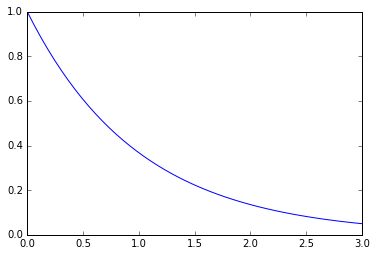

In [7]:
sol = odeint(f, y0, t)
plt.plot(t, sol)

### EDOs de orden superior

Tendremos que acordarnos ahora de cómo reducir las ecuaciones de orden. De nuevo, vamos a probar con un ejemplo académico:

$$y + y'' = 0$$

$$\mathbf{y} \leftarrow \pmatrix{y \\ y'}$$

$$\mathbf{f}(\mathbf{y}) = \frac{d\mathbf{y}}{dt} =  \pmatrix{y \\ y'}' = \pmatrix{y' \\ y''} = \pmatrix{y' \\ -y}$$

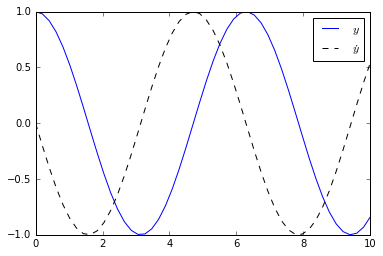

In [8]:
def f(y, t):
    return np.array([y[1], -y[0]])

t = np.linspace(0, 10)
y0 = np.array([1.0, 0.0])

sol = odeint(f, y0, t)

plt.plot(t, sol[:, 0], label='$y$')
plt.plot(t, sol[:, 1], '--k', label='$\dot{y}$')
plt.legend()

## Ecuación de vigas: Modelo de Euler-Bernoulli

*Problema tomado de https://mat.caminos.upm.es/wiki/Ecuaci%C3%B3n_de_vigas:_Modelo_de_Euler-Bernoulli_%2813A%29, por María Aguilera, Paula Martínez, Miguel Sánchez, Laura García, Isabel Roselló y Sarah Boufounas*

¿Qué puede haber más caminero que resolver la ecuación de la viga? En esta sección vamos a estudiar el comportamiento de una viga de 10 metros de longitud y sección rectangular al someterla a la acción de diferentes esfuerzos y variar las dimensiones de su sección transversal, y luego calcularemos la respuesta de esta misma viga al cambiar sus condiciones de apoyo.

![viga](../static/Viga13a.gif)

En este caso, supondremos que el desplazamiento de la viga $y(x)$ y el momento flector $M(x)$ cumplen la curva elástica:

\begin{equation}
y''=\frac{M(x)}{E I(x)}
\end{equation}

### Viga biapoyada sometida a la acción de momentos flectores

Datos:

* $E=5 \cdot 10^4$
* $a=0.6$, $b=0.3$
* $M(x)=\frac{L}{2}−|x−\frac{L}{2}|$

Nos acordamos de la expresión para el momento de inercia:

\begin{equation}
I=\frac{1}{12} b a^3
\end{equation}

(Luego veremos un caso en el que las dimensiones no son constantes a lo largo de la longitud)

En este caso las condiciones de contorno son:

\begin{align}
y(0) & = 0 \\
y(L) & = 0
\end{align}

Como **ya no tenemos un problema de evolución sino un problema de contorno** hay que escoger un método apropiado, así que nosotros vamos a usar el método del disparo (_shooting method_). ¿Por qué?

* Porque en Matewiki está resuelto por diferencias finitas
* Porque así podemos aprovechar lo que ya sabemos de problemas de evolución
* Porque en el fondo a nadie le gusta ensamblar matrices :)

Como no tenemos todas las condiciones iniciales, el método del disparo consiste en:

1. Probar una solución inicial.
2. Resolver el problema y comprobar si el otro extremo coincide con la condición de contorno dada.
3. Iterar hasta converger.

¡Vamos allá!

En primer lugar, probamos a resolver el problema con estas condiciones iniciales:

\begin{align}
y(0) & = 0 \\
y'(0) & = 5 \cdot 10^{-3}
\end{align}

Para comprobar que la solución no coincide con lo que buscamos.

array([-0.03703716,  0.04259256])

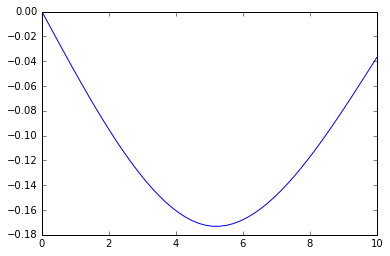

In [9]:
def f(y, x):
    return np.array([y[1], M(x) / (E * I(x))])

# Datos
L = 10
E = 5e4
a, b = 0.6, 0.3

# Dominio
x = np.linspace(0, L, num=50)

# Inercia
def I(x):
    return b * a**3 / 12

# Momento flector
def M(x):
    return L/2 - np.abs(x - L/2)

# Probamos solución
yp0 = -5e-2  # Prueba
y0 = np.array([0, yp0])

sol = odeint(f, y0, x)

plt.plot(t, sol[:, 0], label='$y$')
sol[-1, :]

Ahora iteramos sobre el desplazamiento en $L$ para converger a una solución buena. Para ello, vamos a crear una función:

* **Entrada**: $\tilde{y}'(0)$
* **Salida**: $y(L)$

In [10]:
def viga_biap(yp0):
    y0 = np.array([0, yp0])
    sol = odeint(f, y0, x)
    return sol[-1, 0]

viga_biap(5e-2)

0.96296297642903061

Y ahora la resolvemos utilizando el [método de la bisección](http://pybonacci.org/2012/04/18/ecuaciones-no-lineales-metodo-de-biseccion-y-metodo-de-newton-en-python/) o alguna función de `scipy.optimize`.

In [11]:
from scipy.optimize import newton
newton(viga_biap, 5e-2)

-0.046296287367577141

¡Y ya lo tenemos!

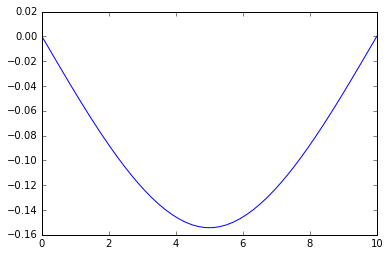

In [12]:
yp0 = newton(viga_biap, 5e-2)
y0 = np.array([0, yp0])

sol = odeint(f, y0, x)

plt.plot(t, sol[:, 0], label='$y$')

## Para ampliar

* En nuestra edición anterior del curso de AeroPython puedes ver una aplicación muy interesante de lo que hemos visto hasta ahora al [**salto de Felix Baumgartner**](http://nbviewer.ipython.org/github/AeroPython/Curso_AeroPython/blob/v1.0/Notebooks/Clase6b_Finale.ipynb):

$$\displaystyle m \frac{d^2 y}{d t^2} = -m g + D$$

* Nuestro compañero Álex escribió un fenomenal artículo en Pybonacci sobre [el modelo presa depredador de Lotka Volterra](http://pybonacci.org/2015/01/05/ecuaciones-de-lotka-volterra-modelo-presa-depredador/):

\begin{align*}
\frac{dx}{dt} &= \alpha x - \beta x y \\
\frac{dy}{dt} &= -\gamma y + \delta y x
\end{align*}

* Puedes [modelizar problemas en derivadas parciales utilizando el método de los elementos finitos en Python con FEniCS](http://pybonacci.org/2015/01/20/fenics-resolucion-de-ecuaciones-diferenciales-en-python/), como la ecuación de Poisson:

\begin{equation*}
-\nabla^2 u = f \quad u \in \Omega.
\end{equation*}

---

Clase en vídeo, parte del [Curso de Python para científicos e ingenieros](http://cacheme.org/curso-online-python-cientifico-ingenieros/) grabado en la Escuela Politécnica Superior de la Universidad de Alicante.

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo("1R_JnTajrRY", width=560, height=315, list="PLGBbVX_WvN7bMwYe7wWV5TZt1a58jTggB")

---

Si te ha gustado esta clase:

<a href="https://twitter.com/share" class="twitter-share-button" data-url="https://github.com/AeroPython/Curso-AeroPython-UC3M/" data-text="Aprendiendo Python con" data-via="AeroPython" data-size="large" data-hashtags="AeroPython">Tweet</a>
<script>!function(d,s,id){var js,fjs=d.getElementsByTagName(s)[0],p=/^http:/.test(d.location)?'http':'https';if(!d.getElementById(id)){js=d.createElement(s);js.id=id;js.src=p+'://platform.twitter.com/widgets.js';fjs.parentNode.insertBefore(js,fjs);}}(document, 'script', 'twitter-wjs');</script>

---

#### <h4 align="right">¡Síguenos en Twitter!

###### <a href="https://twitter.com/AeroPython" class="twitter-follow-button" data-show-count="false">Follow @AeroPython</a> <script>!function(d,s,id){var js,fjs=d.getElementsByTagName(s)[0],p=/^http:/.test(d.location)?'http':'https';if(!d.getElementById(id)){js=d.createElement(s);js.id=id;js.src=p+'://platform.twitter.com/widgets.js';fjs.parentNode.insertBefore(js,fjs);}}(document, 'script', 'twitter-wjs');</script>  

##### <a rel="license" href="http://creativecommons.org/licenses/by/4.0/deed.es"><img alt="Licencia Creative Commons" style="border-width:0" src="http://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Curso AeroPython</span> por <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Juan Luis Cano Rodriguez y Alejandro Sáez Mollejo</span> se distribuye bajo una <a rel="license" href="http://creativecommons.org/licenses/by/4.0/deed.es">Licencia Creative Commons Atribución 4.0 Internacional</a>.

##### <script src="//platform.linkedin.com/in.js" type="text/javascript"></script> <script type="IN/MemberProfile" data-id="http://es.linkedin.com/in/juanluiscanor" data-format="inline" data-related="false"></script> <script src="//platform.linkedin.com/in.js" type="text/javascript"></script> <script type="IN/MemberProfile" data-id="http://es.linkedin.com/in/alejandrosaezm" data-format="inline" data-related="false"></script>

---
_Las siguientes celdas contienen configuración del Notebook_

_Para visualizar y utlizar los enlaces a Twitter el notebook debe ejecutarse como [seguro](http://ipython.org/ipython-doc/dev/notebook/security.html)_

    File > Trusted Notebook

In [2]:
%%html
<a href="https://twitter.com/AeroPython" class="twitter-follow-button" data-show-count="false">Follow @AeroPython</a>
<script>!function(d,s,id){var js,fjs=d.getElementsByTagName(s)[0],p=/^http:/.test(d.location)?'http':'https';if(!d.getElementById(id)){js=d.createElement(s);js.id=id;js.src=p+'://platform.twitter.com/widgets.js';fjs.parentNode.insertBefore(js,fjs);}}(document, 'script', 'twitter-wjs');</script>

In [1]:
# Esta celda da el estilo al notebook
from IPython.core.display import HTML
css_file = '../static/styles/style.css'
HTML(open(css_file, "r").read())